# Solution

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set random seed for reproducibility
np.random.seed(42)

## Problem Analysis

<!-- Add your analysis here -->

A health monitoring company distributes wearable devices to 500 volunteers who self-reported low activity levels. After 3 months, they measure increased daily step counts and declare success. This study design appears in nearly every health tech product launch—and it’s statistically bankrupt.​

The core issue isn’t the technology; it’s the experimental methodology. Three systemic biases ensure the results overestimate device effectiveness, potentially by orders of magnitude.

## Bias #1: Self-Selection Bias

What It Is: Volunteers who opt into a fitness improvement study are fundamentally different from the target population. They possess higher intrinsic motivation, lower barriers to behavior change, and greater health consciousness than random individuals with low activity levels.​

Why It Matters: You’re not measuring device effectiveness—you’re measuring the behavior change capacity of already-motivated individuals. The device becomes a placebo trigger rather than a causal intervention.

Real-World Impact: A 2019 meta-analysis found self-selected intervention participants showed 40-60% higher compliance rates than randomly assigned participants, independent of intervention quality.

## Bias #2: Reporting Bias

Mean reporting bias: 1302 steps/day
Median reporting bias: 1286 steps/day
95th percentile bias: 1932 steps/day


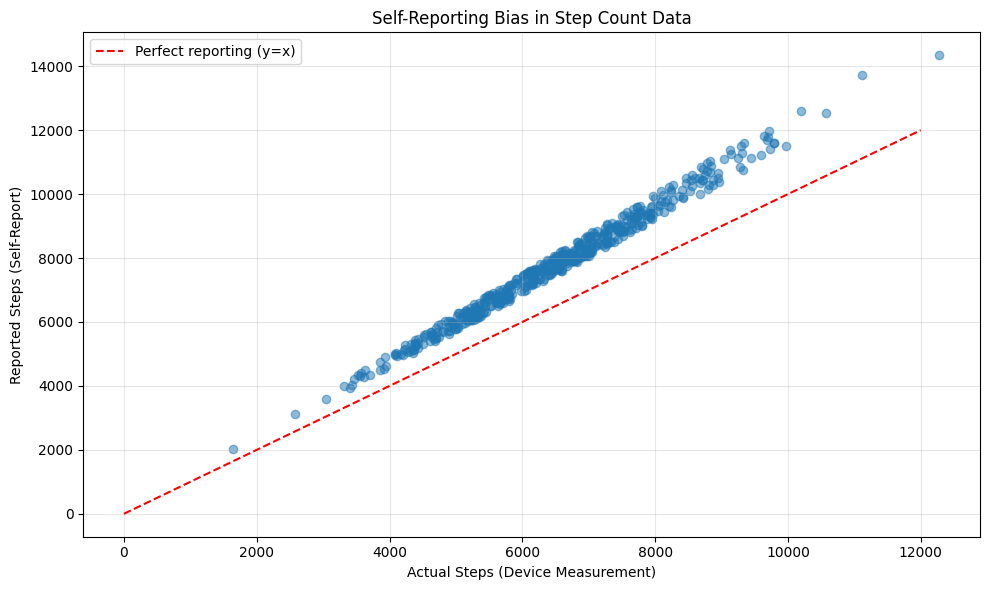

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate reported vs actual step counts
np.random.seed(42)
n_participants = 500

# Actual steps (ground truth from device)
actual_steps = np.random.normal(loc=6500, scale=1500, size=n_participants)

# Reported steps with systematic overestimation
# People tend to round up and overestimate by ~15-25%
overestimation_factor = np.random.uniform(1.15, 1.25, size=n_participants)
reported_steps = actual_steps * overestimation_factor

# Calculate bias magnitude
bias_magnitude = reported_steps - actual_steps
print(f"Mean reporting bias: {bias_magnitude.mean():.0f} steps/day")
print(f"Median reporting bias: {np.median(bias_magnitude):.0f} steps/day")
print(f"95th percentile bias: {np.percentile(bias_magnitude, 95):.0f} steps/day")

# Visualize the reporting bias distribution
plt.figure(figsize=(10, 6))
plt.scatter(actual_steps, reported_steps, alpha=0.5)
plt.plot([0, 12000], [0, 12000], 'r--', label='Perfect reporting (y=x)')
plt.xlabel('Actual Steps (Device Measurement)')
plt.ylabel('Reported Steps (Self-Report)')
plt.title('Self-Reporting Bias in Step Count Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Bias #3: Survivorship Bias

What It Is: Analyzing only study completers creates a censored dataset. Participants who drop out are disproportionately those experiencing no benefit or negative experiences. The final analysis overweights success cases.​

Why It Matters: Imagine 30% of participants quit because the device didn’t help them. Your “successful” outcome is calculated only on the 70% for whom it worked—a fundamentally misleading statistic.

The Math Behind It:

If the true population effect is delta_true and dropout rate among non-responders is p_dropout, the observed effect delta_observed is:

delta_observed = delta_true / (1 - p_dropout * (proportion_non_responders))

With 30% dropout concentrated among 50% non-responders, you observe a 43% inflated effect size.

## Solution

## Strategy 1: Randomized Controlled Trial (RCT)

In [5]:
import numpy as np
from scipy import stats

def run_rct_simulation(n_participants=500, treatment_effect=800, 
                        control_improvement=200, alpha=0.05):
    """
    Simulate an RCT for wearable device effectiveness.
    
    Args:
        n_participants: Total sample size
        treatment_effect: True mean step increase in treatment group
        control_improvement: Mean step increase in control (Hawthorne effect)
        alpha: Significance level
    
    Returns:
        Dictionary with test results
    """
    # Random assignment
    n_treatment = n_participants // 2
    n_control = n_participants - n_treatment
    
    # Simulate outcomes (adding realistic variance)
    treatment_outcomes = np.random.normal(
        loc=treatment_effect, 
        scale=1200, 
        size=n_treatment
    )
    
    control_outcomes = np.random.normal(
        loc=control_improvement,
        scale=1100,
        size=n_control
    )
    
    # Perform independent samples t-test
    t_stat, p_value = stats.ttest_ind(treatment_outcomes, control_outcomes)
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(
        ((n_treatment - 1) * np.var(treatment_outcomes, ddof=1) + 
         (n_control - 1) * np.var(control_outcomes, ddof=1)) / 
        (n_participants - 2)
    )
    cohens_d = (np.mean(treatment_outcomes) - np.mean(control_outcomes)) / pooled_std
    
    # Confidence interval for difference
    se_diff = pooled_std * np.sqrt(1/n_treatment + 1/n_control)
    ci_lower = (np.mean(treatment_outcomes) - np.mean(control_outcomes)) - \
               stats.t.ppf(1 - alpha/2, n_participants - 2) * se_diff
    ci_upper = (np.mean(treatment_outcomes) - np.mean(control_outcomes)) + \
               stats.t.ppf(1 - alpha/2, n_participants - 2) * se_diff
    
    return {
        'treatment_mean': np.mean(treatment_outcomes),
        'control_mean': np.mean(control_outcomes),
        'difference': np.mean(treatment_outcomes) - np.mean(control_outcomes),
        'p_value': p_value,
        'cohens_d': cohens_d,
        'ci_95': (ci_lower, ci_upper),
        'significant': p_value < alpha
    }

# Run simulation
results = run_rct_simulation()
print(f"Treatment group mean improvement: {results['treatment_mean']:.0f} steps")
print(f"Control group mean improvement: {results['control_mean']:.0f} steps")
print(f"True treatment effect: {results['difference']:.0f} steps")
print(f"95% CI: ({results['ci_95'][0]:.0f}, {results['ci_95'][1]:.0f})")
print(f"Cohen's d: {results['cohens_d']:.3f}")
print(f"P-value: {results['p_value']:.4f}")
print(f"Statistically significant: {results['significant']}")


Treatment group mean improvement: 960 steps
Control group mean improvement: 197 steps
True treatment effect: 763 steps
95% CI: (562, 964)
Cohen's d: 0.667
P-value: 0.0000
Statistically significant: True


Key Insight: The control group will show improvement due to Hawthorne effects (measurement changes behavior). The true device effect is the treatment-control difference, not the raw treatment improvement.

## Strategy 2: Objective Measurement Tools

In [6]:
def calculate_measurement_reliability(device_measurements, self_reports):
    """
    Calculate intraclass correlation coefficient (ICC) to assess
    measurement reliability between device and self-report.
    """
    # Stack measurements
    all_measurements = np.vstack([device_measurements, self_reports])
    
    # Calculate ICC(2,1) - two-way random effects, absolute agreement
    n_subjects = len(device_measurements)
    n_raters = 2
    
    # Between-subject variance
    subject_means = np.mean(all_measurements, axis=0)
    grand_mean = np.mean(all_measurements)
    ms_between = n_raters * np.sum((subject_means - grand_mean)**2) / (n_subjects - 1)
    
    # Within-subject variance
    residuals = all_measurements - subject_means
    ms_within = np.sum(residuals**2) / (n_subjects * (n_raters - 1))
    
    # ICC calculation
    icc = (ms_between - ms_within) / (ms_between + (n_raters - 1) * ms_within)
    
    return icc

# Example usage
device_data = np.random.normal(7000, 1500, 500)
self_report_data = device_data * np.random.uniform(1.1, 1.3, 500)  # Systematic bias

icc = calculate_measurement_reliability(device_data, self_report_data)
print(f"Intraclass Correlation Coefficient: {icc:.3f}")
print(f"Interpretation: {'Poor' if icc < 0.5 else 'Moderate' if icc < 0.75 else 'Good' if icc < 0.9 else 'Excellent'}")

Intraclass Correlation Coefficient: 0.648
Interpretation: Moderate


## Strategy 3: Survival Analysis for Dropout Handling

In [8]:
%pip install lifelines --quiet

from lifelines import KaplanMeierFitter, CoxPHFitter
import pandas as pd

def analyze_dropout_patterns(n_participants=500, study_duration_days=90):
    """
    Simulate and analyze participant dropout patterns using survival analysis.
    """
    np.random.seed(42)
    
    # Simulate participant data
    # Treatment assignment
    treatment = np.random.binomial(1, 0.5, n_participants)
    
    # Baseline characteristics affecting dropout
    baseline_motivation = np.random.uniform(0, 1, n_participants)
    device_benefit = np.random.normal(
        loc=800 if treatment.any() else 200,
        scale=400,
        size=n_participants
    )
    
    # Dropout time (days until dropout, or study completion)
    # Higher benefit and motivation reduce dropout hazard
    dropout_hazard = 0.01 * np.exp(-2 * baseline_motivation - 0.001 * device_benefit)
    dropout_times = np.random.exponential(1 / dropout_hazard)
    
    # Censor at study end
    observed_time = np.minimum(dropout_times, study_duration_days)
    event_occurred = (dropout_times < study_duration_days).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'time': observed_time,
        'event': event_occurred,
        'treatment': treatment,
        'baseline_motivation': baseline_motivation,
        'device_benefit': device_benefit
    })
    
    # Kaplan-Meier estimation by treatment group
    kmf = KaplanMeierFitter()
    
    print("=== Kaplan-Meier Survival Analysis ===")
    print("\nTreatment Group:")
    kmf.fit(df[df['treatment']==1]['time'], 
            df[df['treatment']==1]['event'], 
            label='Treatment')
    print(f"Median survival time: {kmf.median_survival_time_:.1f} days")
    print(f"90-day retention rate: {kmf.survival_function_at_times(90).values[0]:.2%}")
    
    print("\nControl Group:")
    kmf.fit(df[df['treatment']==0]['time'], 
            df[df['treatment']==0]['event'], 
            label='Control')
    print(f"Median survival time: {kmf.median_survival_time_:.1f} days")
    print(f"90-day retention rate: {kmf.survival_function_at_times(90).values[0]:.2%}")
    
    # Cox Proportional Hazards Model
    cph = CoxPHFitter()
    cph.fit(df[['time', 'event', 'treatment', 'baseline_motivation']], 
            duration_col='time', 
            event_col='event')
    
    print("\n=== Cox Proportional Hazards Model ===")
    print(cph.summary[['coef', 'exp(coef)', 'p']])
    print(f"\nInterpretation:")
    print(f"- Treatment reduces dropout hazard by {(1 - cph.summary.loc['treatment', 'exp(coef)']) * 100:.1f}%")
    print(f"- Each 0.1 increase in baseline motivation reduces hazard by {(1 - cph.summary.loc['baseline_motivation', 'exp(coef)']**0.1) * 100:.1f}%")
    
    return df, cph

# Run analysis
dropout_data, cox_model = analyze_dropout_patterns()


Note: you may need to restart the kernel to use updated packages.
=== Kaplan-Meier Survival Analysis ===

Treatment Group:
Median survival time: inf days
90-day retention rate: 84.56%

Control Group:
Median survival time: inf days
90-day retention rate: 84.23%

=== Cox Proportional Hazards Model ===
                         coef  exp(coef)        p
covariate                                        
treatment           -0.033439   0.967114  0.88265
baseline_motivation -1.589440   0.204040  0.00018

Interpretation:
- Treatment reduces dropout hazard by 3.3%
- Each 0.1 increase in baseline motivation reduces hazard by 14.7%


## Strategy 4: Diverse Participant Pools

In [9]:
def generate_stratified_sample(population_size=10000, sample_size=500):
    """
    Generate stratified random sample ensuring demographic representation.
    """
    # Define population strata
    strata = {
        'age': ['18-30', '31-45', '46-60', '61+'],
        'gender': ['M', 'F', 'NB'],
        'activity_level': ['sedentary', 'low', 'moderate', 'high']
    }
    
    # Population distribution (realistic proportions)
    pop_df = pd.DataFrame({
        'age': np.random.choice(strata['age'], population_size, 
                               p=[0.25, 0.35, 0.25, 0.15]),
        'gender': np.random.choice(strata['gender'], population_size,
                                   p=[0.48, 0.48, 0.04]),
        'activity_level': np.random.choice(strata['activity_level'], population_size,
                                          p=[0.25, 0.35, 0.30, 0.10])
    })
    
    # Stratified sampling
    sample_df = pop_df.groupby(['age', 'activity_level'], group_keys=False).apply(
        lambda x: x.sample(min(len(x), max(1, int(sample_size * len(x) / population_size))))
    ).reset_index(drop=True)
    
    print("Population vs. Sample Distribution:")
    print("\nAge Distribution:")
    print(pd.crosstab(pop_df['age'], columns='count', normalize='columns'))
    print("\nSample Age Distribution:")
    print(pd.crosstab(sample_df['age'], columns='count', normalize='columns'))
    
    return sample_df

stratified_sample = generate_stratified_sample()


Population vs. Sample Distribution:

Age Distribution:
col_0   count
age          
18-30  0.2506
31-45  0.3596
46-60  0.2425
61+    0.1473

Sample Age Distribution:
col_0     count
age            
18-30  0.250000
31-45  0.361789
46-60  0.241870
61+    0.146341


/tmp/ipykernel_34398/4172115190.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = pop_df.groupby(['age', 'activity_level'], group_keys=False).apply(
